In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import pickle
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import easydict

In [2]:
sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
times = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
def moulti_fit(s, t, max_step=14):
    with open('data/enregistrement_%s_%s.pkl'%(sujets[s], times[s]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[s], times[s])

    A = ANEMO(exp) 
    Fit = ANEMO.Fit(exp)
    Plot = ANEMO.Plot(exp)

    #= 1 ===============================================================================================
    data_full = read_edf(datafile, 'TRIALID')

    Plot.plot_fit(data_full, trials=t, fig_width=30)

    arg = A.arg(data_full[t], trial=t, block=0)
    velocity = A.velocity_NAN(**arg)
    old_latency, old_steady_state, old_anti = A.classical_method.Full(velocity, arg.TargetOn-arg.t_0)
    rere = Fit.Fit_trial(velocity, value_latency=old_latency, value_steady_state=old_steady_state, value_anti=old_anti, **arg)
    
    result_full_data = rere.values
    for k in ['latency', 'start_anti'] :
        result_full_data[k] = result_full_data[k] - (arg.TargetOn-arg.t_0)
    #print('result_full_data =', result_full_data)

    #= 2 ===============================================================================================
    color = []
    for nb in range(20) :
        color.append([])
        a = [0,0,0]
        for i in range(nb+2) :
            a[nb%3] = 1/(i+1)
            color[nb].append(tuple(a))

    result_red_data = []

    for n, nb in enumerate(np.arange(2, max_step)) :
        result_red_data.append([])
        for i in np.arange(nb) :
            #print(nb, i)
            
            data_red = read_edf(datafile, 'TRIALID')
            for var in data_red[t].keys() :
                if var != 'events' :
                    data_red[t][var] = np.array([data_red[t][var][x] for x in range(i, len(data_red[t][var]), nb)])        
            arg_red = A.arg(data_red[t], trial=t, block=0)

            #===================================================================
            max_latency = []
            for s in range(len(arg_red.saccades)) :
                if (arg_red.saccades[s][0]-arg_red.t_0) >= (arg_red.TargetOn-arg_red.t_0+100):
                    max_latency.append(int((arg_red.saccades[s][0]-arg_red.t_0)/nb))
            if max_latency == [] :
                max_latency.append(len(arg_red.trackertime[:-int(280/nb)]))
            max_latency = max_latency[0]

            #----------------------------------------------
            a = easydict.EasyDict()
            for v in ['StimulusOn', 'StimulusOf', 'TargetOn', 'TargetOff','t_0']:
                a[v] = int(arg_red[v]/nb)

            veve = [velocity[t] for t in np.arange(i, len(velocity), nb)]
            value_latency = A.classical_method.latency(veve)
            value_anti = np.nanmean(veve[(a.TargetOn-a.t_0)-int(50/nb):(a.TargetOn-a.t_0)+int(50/nb)])
            value_steady_state = abs(np.nanmean(veve[(a.TargetOn-a.t_0)+int(400/nb):(a.TargetOn-a.t_0)+int(600/nb)]))

            if value_latency >= max_latency-(50/nb) : value_latency = max_latency-(150/nb)
            if value_latency > (250/nb) :             value_latency = a.TargetOn-a.t_0+(100/nb)

            #----------------------------------------------
            #print(value_latency, value_anti, value_steady_state)
            if np.isnan(value_latency) : value_latency = a.TargetOn-a.t_0+(100/nb)

            param_fit=[{'name':'steady_state', 'value':value_steady_state, 'min':5., 'max':40., 'vary':True  },
                       {'name':'dir_target',   'value':arg_red.dir_target, 'min':None, 'max':None, 'vary':False },
                       {'name':'a_anti',       'value':value_anti,         'min':-40., 'max':40., 'vary':True  },
                       {'name':'latency',      'value':value_latency,
                             'min':a.TargetOn-a.t_0+(75/nb), 'max':max_latency, 'vary':True  },
                       {'name':'start_anti',   'value':a.TargetOn-a.t_0-(100/nb),
                            'min':a.StimulusOf-a.t_0-(200/nb), 'max':a.TargetOn-a.t_0+(75/nb), 'vary':'vary'},
                       {'name':'tau',  'value':15., 'min':13., 'max':80., 'vary':'vary'}]

            inde_vars={'x':np.arange(len(arg_red.trackertime[:-int(280/nb)]))}

            #===================================================================
            #Plot.plot_data(data_red, trials=t)
            plt.plot(arg_red.trackertime-arg_red.TargetOn, veve, c=color[n][i], alpha=.3);

            rere = Fit.Fit_trial(veve, param_fit=param_fit, inde_vars=inde_vars, time_sup=int(280/nb))
            result_red = rere.values
            for k in ['latency', 'start_anti'] :
                result_red[k] = result_red[k]*nb

            fit = A.Equation.fct_velocity(arg_red.trackertime[:-int(280/nb)]-arg_red.t_0, **result_red)
            plt.plot(arg_red.trackertime[:-int(280/nb)]-arg_red.TargetOn, fit, c=color[n][i])

            for k in ['latency', 'start_anti'] :
                result_red[k] = result_red[k] - (arg_red.TargetOn-arg_red.t_0)
            
            #print(nb, i, 'result_red_data =', result_red)
            result_red_data[n].append(result_red)
            
    return(result_full_data, result_red_data)

In [4]:
def histoto(result_full_data_, result_red_data_, name, color, bins=50):
    
    
    x_range = {'steady_state': [5, 40],
               'a_anti':       [-40, 40],
               'latency':      [75, 300],
               'start_anti':   [-500, 75],
               'tau':          [13, 80]
               }
    
    list_, list_var = result_full_data_[0].keys(), []
    for v in list_: 
        if v not in ['dir_target', 'do_whitening'] : list_var.append(v)

    nb_var = len(list_var)
    fig, ax = plt.subplots(nb_var, len(result_full_data_), figsize=(5*len(result_full_data_),5*nb_var/1.681))
    
    
    for r in range(len(result_full_data_)) :
        
        result_full_data = result_full_data_[r]
        result_red_data = result_red_data_[r]
        
        
        for nb_var, v in enumerate(list_var) :
        
            result_v = []
            for n in range(len(result_red_data)) :
                for i in range(len(result_red_data[n])) :
                    result_v.append(result_red_data[n][i][v])

            hi = ax[nb_var][r].hist(result_v, range=x_range[v], color=color[r], alpha=.7, density=True, bins=bins)#, histtype='step', align='mid')
            ax[nb_var][r].bar(result_full_data[v], np.max(hi[0]), width=(x_range[v][0]-x_range[v][1])/(bins*2), color='k')    
            ax[nb_var][r].set_title(v+name[r])

IP


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

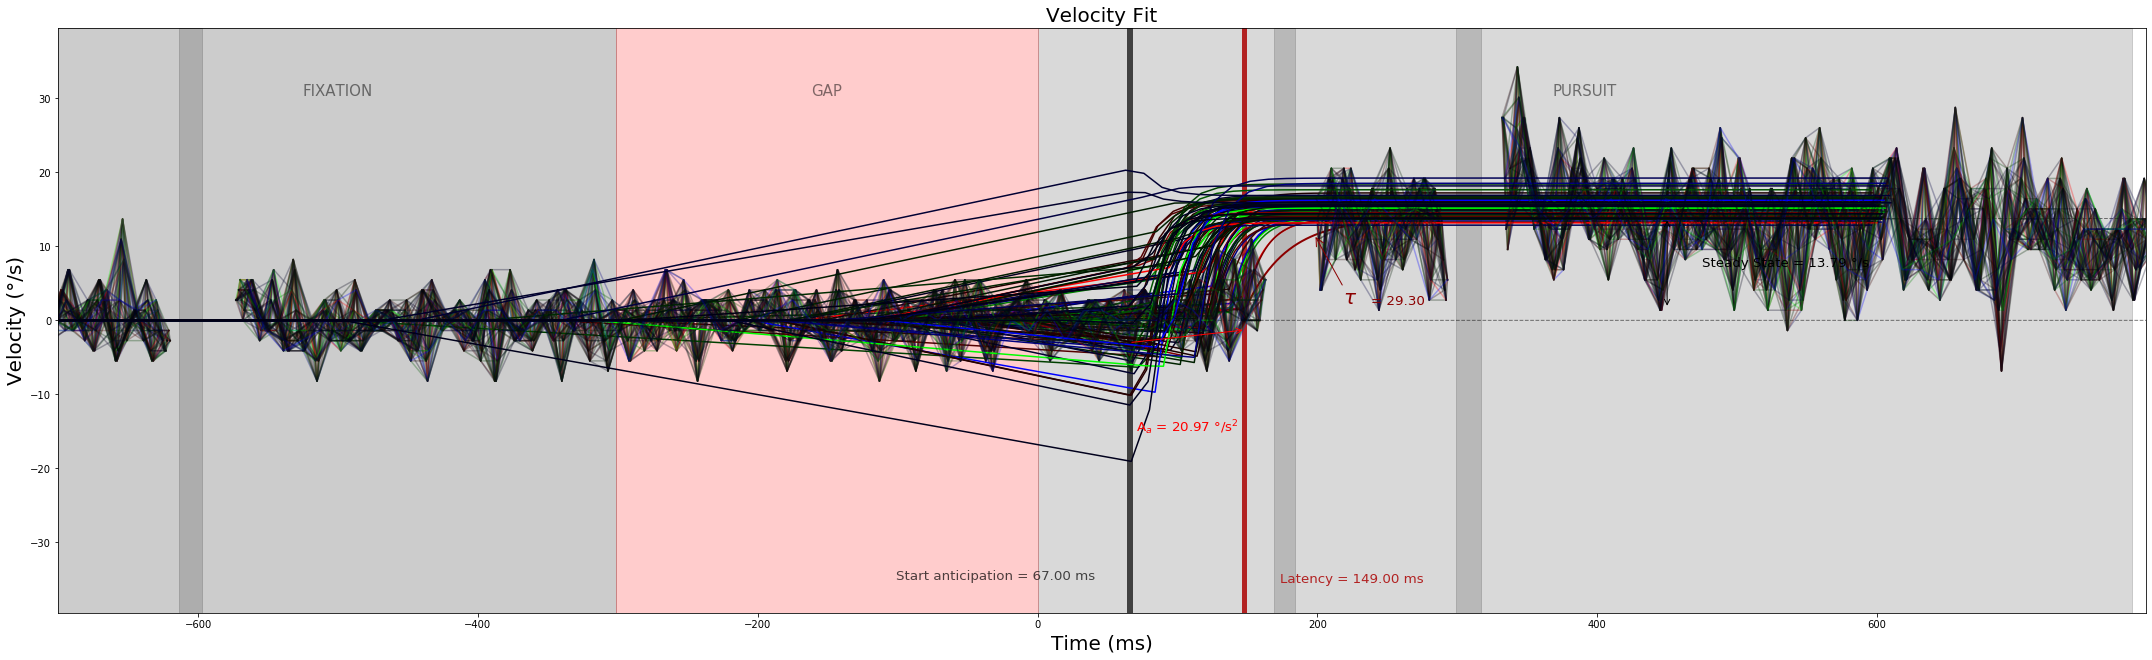

In [5]:
s = 5
t = 11
print(sujets[s])

result_full_data_s5, result_red_data_s5 = moulti_fit(s, t)

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

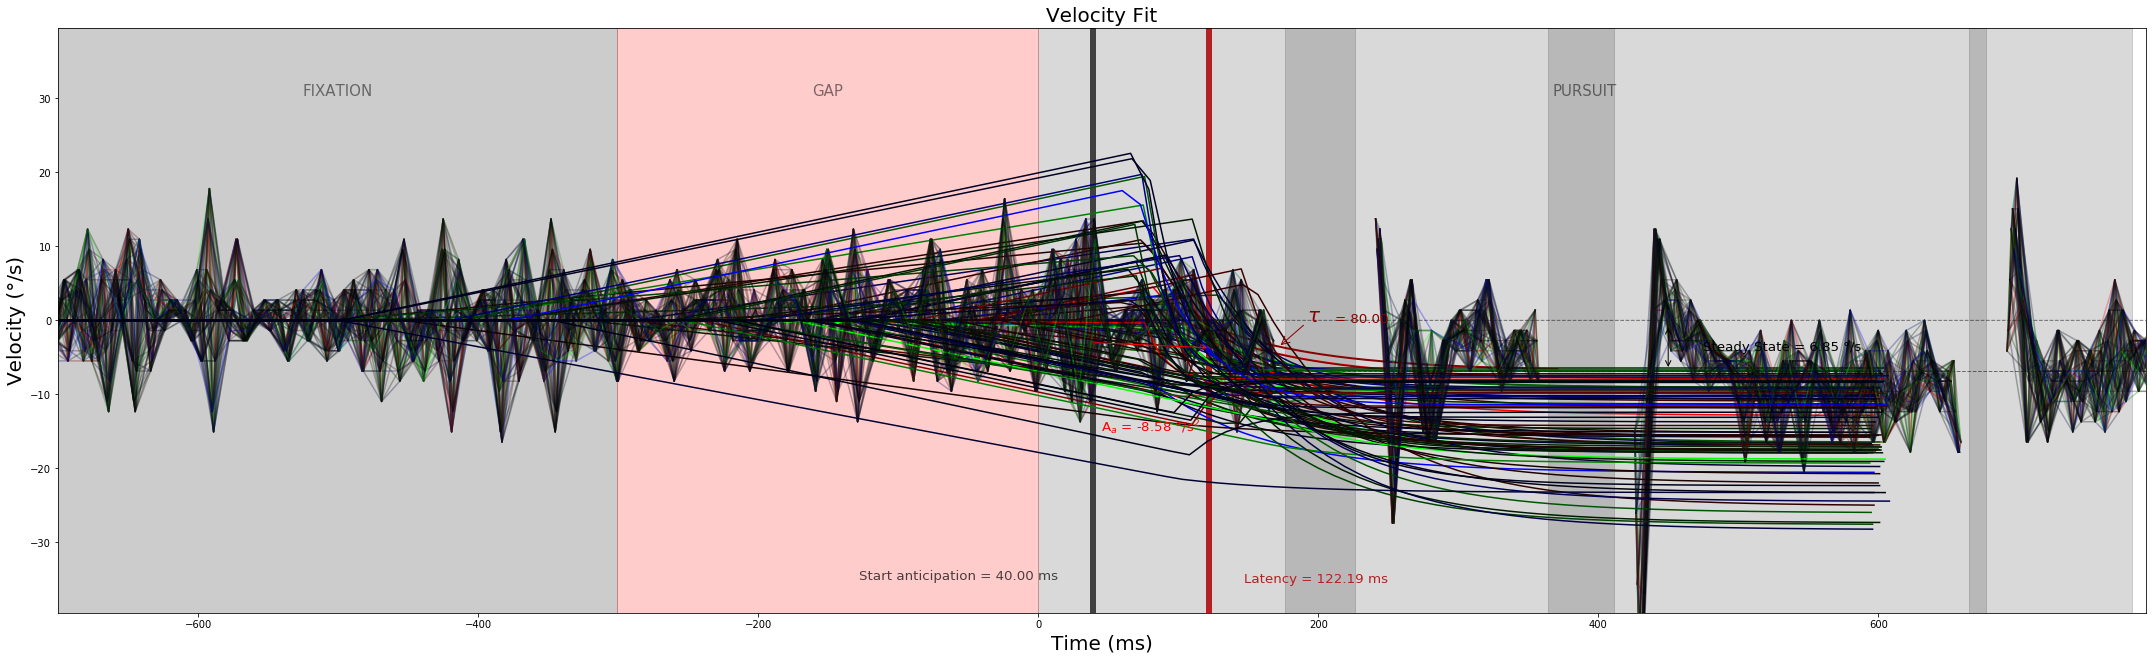

In [6]:
s = 11
t = 189
print(sujets[s])

result_full_data_s11_189, result_red_data_s11_189 = moulti_fit(s, t)

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/lo

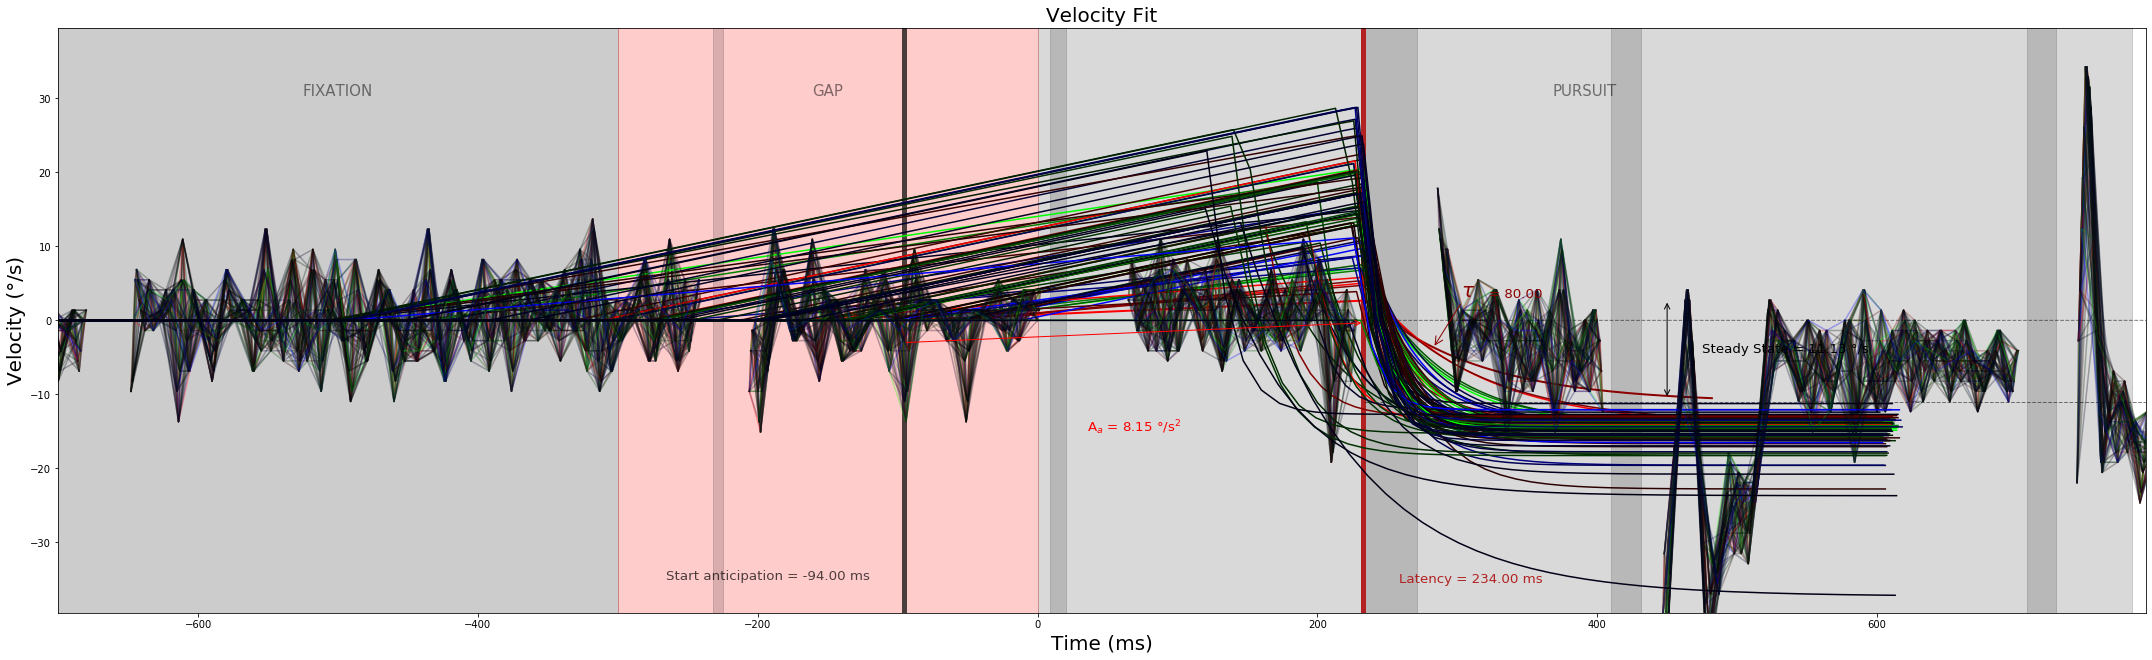

In [7]:
s = 11
t = 190
print(sujets[s])

result_full_data_s11_190, result_red_data_s11_190 = moulti_fit(s, t)

YK


/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in double_scalars
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:782: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/usr/local/lib/python3.6/dist-packages/lmfit/minimizer.py:789: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jva

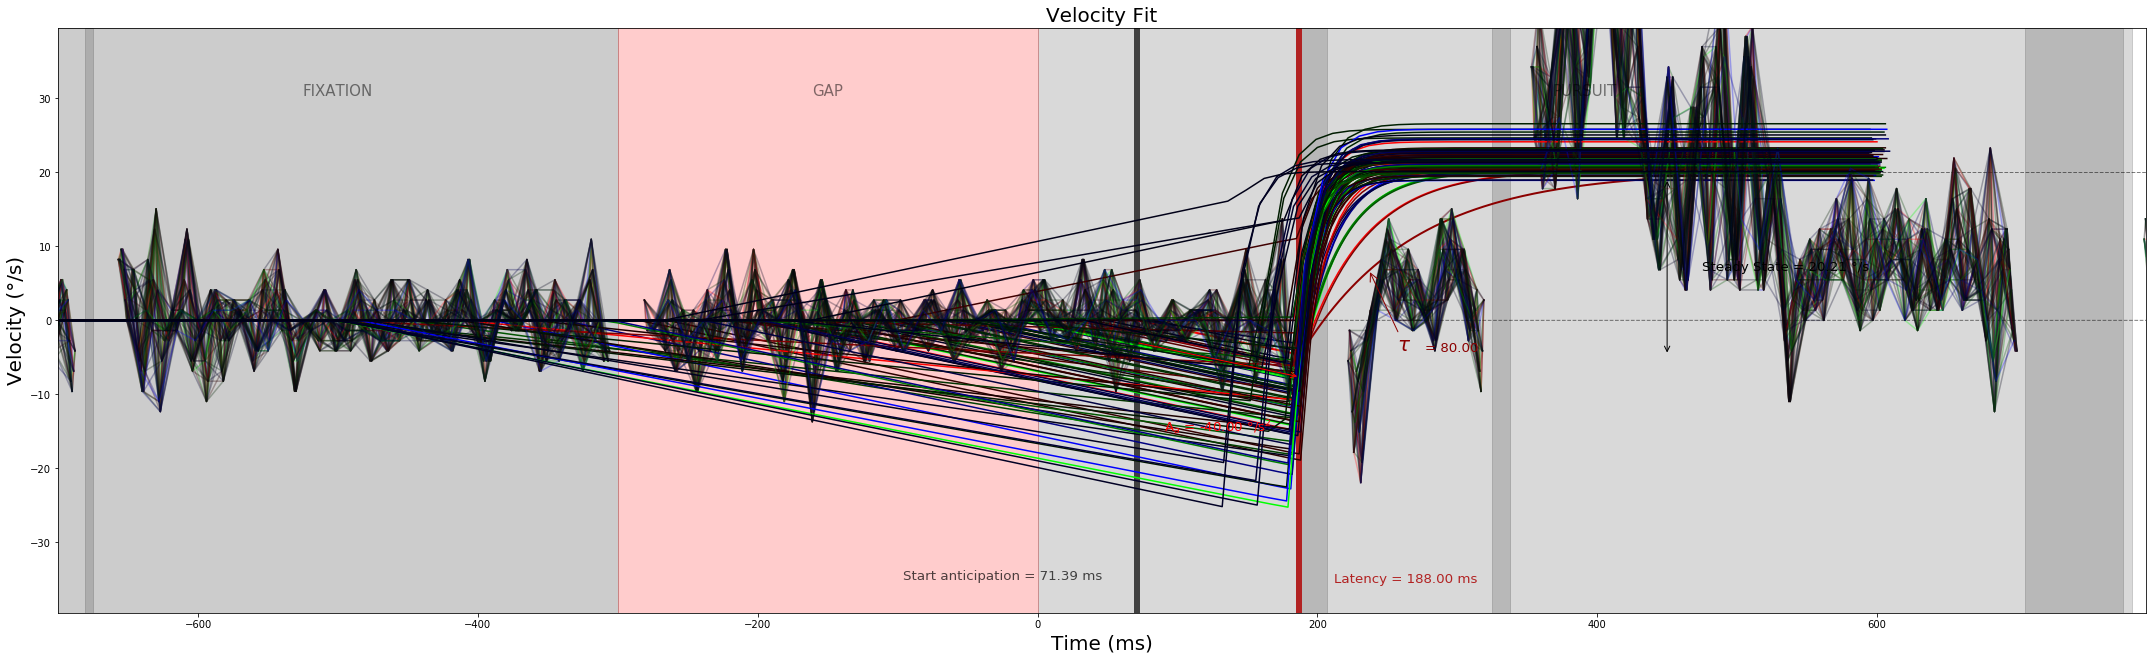

In [8]:
s = 11
t = 191
print(sujets[s])

result_full_data_s11_191, result_red_data_s11_191 = moulti_fit(s, t)

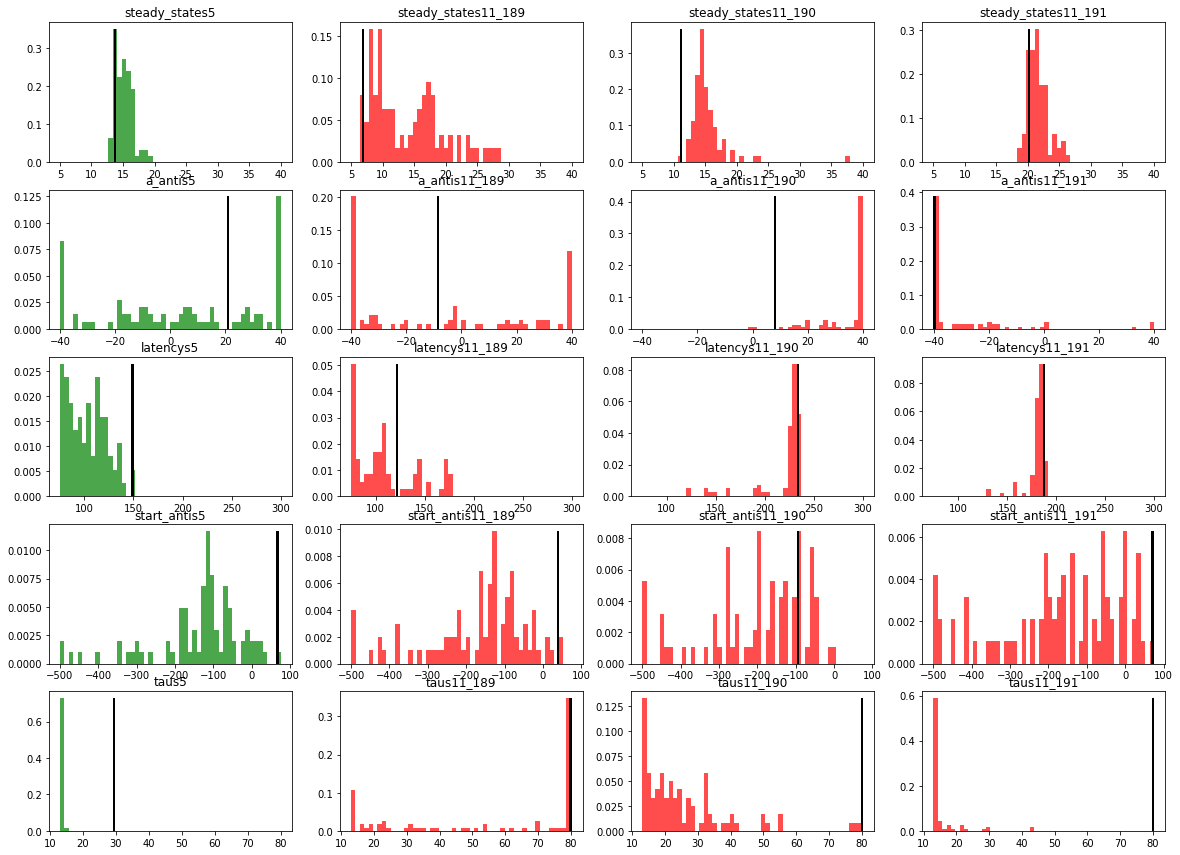

In [9]:
histoto([result_full_data_s5,result_full_data_s11_189,result_full_data_s11_190,result_full_data_s11_191],
        [result_red_data_s5,result_red_data_s11_189,result_red_data_s11_190,result_red_data_s11_191],
        ['s5', 's11_189', 's11_190', 's11_191'],
        [ 'g',       'r',       'r',       'r'])